In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from datetime import date, datetime
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pandas as pd

### Spark High Leve API

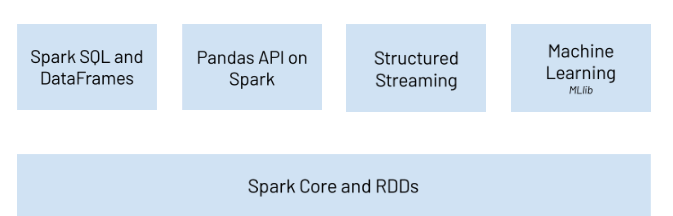

#### Spark SQL 및 DataFrames

- 생성 타입 : pyspark.sql.dataframe.DataFrame
- Spark SQL은 구조화된 데이터로 작업하기 위한 Apache Spark의 모듈
- SQL 쿼리를 Spark 프로그램과 원활하게 혼합가능 하고, PySpark DataFrames를 사용하면 Python과 SQL 사용 가능
- 효율적으로 데이터를 읽고, 쓰고, 변환하고, 분석
- Python사용이든 SQL을 사용하든 동일한 기본 실행 엔진이 사용되므로 항상 Spark의 모든 기능을 활용할 수 있다

### Spark에서의 Pandas API

- 생성 타입 : pyspark.pandas.dataframe.DataFrame
- Spark은 Pandas API를 제공 함
- 여러 노드에 분산하여 처리 가능
- 이미 pandas에 익숙하고 빅데이터에 Spark를 활용하려는 경우 Spark의 pandas API를 사용
- pandas(테스트, 소규모 데이터 세트)와 Spark(프로덕션, 분산 데이터 세트) 모두에서 작동하는 단일 코드베이스를 가질 수 있음
- core pandas API와 Spark의 Pandas API 간에 오버헤드 없이 쉽게 전환가능 함
- 단, Koalas 프로젝트로 시작 되었으며, 현재는 aparch 프로젝트로 포함됨
    - 2019년 시작된 프로젝트로 지금은 databricks에서도 진행되고 있음
    - 아직 안정성이 완전하지는 않음

### Python에서의 Pandas API
-  구조화된 테이블 형식 데이터로 작업하는데 가장 많이 사용되는 오픈소스 Python 라이브러리 중 하나
-  분산처리를 지원하지 않으므로 증가하는 데이터를 지원하기 위해 추가적인 리소스 할당이 필요
-  생성 후 수정이 가능하고, 지연연산을 진행하지 않는다

## 1) Pandas core DataFrame으로 spark DataFrame을 생성
- **spark.createDataFrame(pandasDF)** : pandasDF -> sparkDF
    - **pyspark.sql.dataframe.DataFrame** : schema를 갖게되면 지연연산을 진행
    - sparkDF로 변환 시 pd.DataFrame.iteritems 속성값을 전달해야 함
        - pandas 2.0이상 버전에서는  pd.DataFrame.iteritems이 빈값으로 존재
        - pd.DataFrame.itmes라는 속성에  iteritems값이 들어 있다
        - **pd.DataFrame.iteritems = pd.DataFrame.items**



In [3]:
pandas_df = pd.DataFrame({
    'name':['김철수','이제동','김명운'],
    'age':[20, 21, 22],
    'birth':[date(2022,7,1),date(2022,7,2),date(2022,7,3)]
})

type(pandas_df)
pandas_df

pandas.core.frame.DataFrame

,name,age,birth
0,김철수,20,2022-07-01
1,이제동,21,2022-07-02
2,김명운,22,2022-07-03


In [4]:
## pandas 2.0 버전 이상부터 iteritems atrr이 items로 변경됨
# sprk.createDataFrame은 pd.DataFrame.iteritems를 사용하므로 변경 반영 후 사용해야 함
pd.DataFrame.iteritems = pd.DataFrame.items
pdDF_spDF =spark.createDataFrame(pandas_df)
pdDF_spDF.show()
type(pdDF_spDF)
pdDF_spDF.printSchema()

+------+---+----------+
|  name|age|     birth|
+------+---+----------+
|김철수| 20|2022-07-01|
|이제동| 21|2022-07-02|
|김명운| 22|2022-07-03|
+------+---+----------+



pyspark.sql.dataframe.DataFrame

root
 |-- name: string (nullable = true)
 |-- age: long (nullable = true)
 |-- birth: date (nullable = true)



## 2) spark.SQL.DataFrame으로 Pandas.core.DataFrame을 생성
- 스키마를 포함하고 있는 spark dataframe을 pandas dataframe으로 변환 가능
    - spark df는 pandas df 보다 기능이 적게 구성되어 있음
    - pandas의 기능이 필요할 때 변환해서 사용
    - **sparkDF.toPandas()** : sparkDF -> pandasDF
    - **pandas.core.frame.DataFrame**

In [11]:
# 스파크의 DataFrame을 사용하는 것이 성능상 더 이득
# 스파크는 병렬처리도 해주고... 쿼리실행 최적화도 해주고...
# 하지만 스파크 api가 Pandas에 비해 제공되는 기능이 적어서
# Pandas를 써야만 해결이 가능하다면 Pandas로 가공 이후 스파크 DataFrame으로 변환도 가능
type(pdDF_spDF)
pdDF = pdDF_spDF.toPandas()
type(pdDF)
pdDF #지연연산 안해서 데이터 모양 바로 볼 수 O

pyspark.sql.dataframe.DataFrame

pandas.core.frame.DataFrame

,name,age,birth
0,김철수,20,2022-07-01
1,이제동,21,2022-07-02
2,김명운,22,2022-07-03


## 3) spark.sql DataFrame으로  spark.pandas DataFrame을 생성
- 스키마가 있는 **pyspark.sql.dataframe.DataFrame** 을 **pyspark.pandas.dataframe.DataFrame**으로 변환
    - spark는 pandas api를 갖고 있음
    - spark pandas api는 병렬 분산 처리가 가능하고 데이터 증가에 대응이 가능
    - **spark.sql.DataFrame.pandas_api()**
    - 구버전 : spark.sql.DataFrame.to_pandas_on_spark()

    
- pyspark.pandas 사용하려면 pyarrow 설치하고 해당 기능을 이용하면 됨
- numpy 2.0 이후 버전에서는 pyarrow가 error가 발생하므로 numpy를 다운그레이드 함
- numpy 다운그레이드 이후에도 get_option 에러 발생하면 pysaprk upgrade
- !pip install pyspark==3.5.0 

In [28]:
# !pip uninstall numpy 
# !pip install "numpy<2.0"
# 패키지 버전 변경 시 서버 재실행 해야 제대로 동작함

In [29]:
# !pip install pyarrow

In [35]:
import os
os.environ['PYARROW_IGNORE_TIMEZONE']='1'
# pyarrow 설정에 셋팅을 맞춰주는 코드로 없으면 강력한 warn 메시지 출력 됨

In [13]:
# pyspark.sql.dataframe을 pysaprk.pandas.dataframe으로 변환
type(pdDF_spDF)
pdAPI = pdDF_spDF.pandas_api()
type(pdAPI)
pdAPI

pyspark.sql.dataframe.DataFrame

/root/spark/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


pyspark.pandas.frame.DataFrame

,name,age,birth
0,김철수,20,2022-07-01
1,이제동,21,2022-07-02
2,김명운,22,2022-07-03


In [34]:
# pyspark.sql.dataframe을 pysaprk.pandas.dataframe으로 변환2
type(pdDF_spDF)
pdAPI = pdDF_spDF.to_pandas_on_spark() # DataFrame.to_pandas_on_spark is deprecated. 1에서 이용한 pandas_api()를 쓰라고함.
type(pdAPI)
pdAPI

pyspark.sql.dataframe.DataFrame

/root/spark/python/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


pyspark.pandas.frame.DataFrame

,name,birth
0,김철수,2022-07-01
1,이제동,2022-07-02
2,김명운,2022-07-03


In [16]:
# spark 엔진을 어느정도 사용하고있는 api(spark.PandasAPI)
pdAPI.schema # 에러발생(스키마가 존재하지 않는 spark pandas api df == 지연연산X)

AttributeError: 'DataFrame' object has no attribute 'schema'

### pandas.core.DF vs spark.pandas.DF

- pdDF : 위에서 생성한 pandas.core.DF
- pdAPI : 위에서 생성한 spark.pandas.DF
- 두 df가 거의 유사한 모듈 및 수정 삭제를 사용할 수 있다
- 단, pandas.core.DF는 분산처리가 불가능 하며, spark.pandas.DF는 분산처리가 가능하다

In [21]:
type(pdDF)
pdDF # 전체 DF반환
pdDF['age'] # 특정컬럼 인덱싱 -> 시리즈로 반환
pdDF[['age']] # 특정컬럼 인덱싱 -> DF로 반환
pdDF[['age', 'name']] # 여러컬럼 인덱싱(반드시 리스트로 묶어야함) -> DF로 반환
pdDF.loc[0] # 특정 행 인덱싱 -> 시리즈로 반환
pdDF.loc[0, ['age', 'name']] # 특정 행의 일부 컬럼 인덱싱 -> 시리즈로 반환
pdDF.loc[0, 'name']='홍길동' # DF값 부분 수정
pdDF
pdDF.drop(labels='age', axis=1) # 컬럼 삭제 후 df반환 -> 원본변경X
pdDF #여전히 age가 살아있는 데이터 출력됨.
# 컬럼삭제 하려면 대입연산자 사용해야함

pandas.core.frame.DataFrame

,name,age,birth
0,홍길동,20,2022-07-01
1,이제동,21,2022-07-02
2,김명운,22,2022-07-03


0    20
1    21
2    22
Name: age, dtype: int64

,age
0,20
1,21
2,22


,age,name
0,20,홍길동
1,21,이제동
2,22,김명운


name            홍길동
age              20
birth    2022-07-01
Name: 0, dtype: object

age      20
name    홍길동
Name: 0, dtype: object

,name,age,birth
0,홍길동,20,2022-07-01
1,이제동,21,2022-07-02
2,김명운,22,2022-07-03


,name,birth
0,홍길동,2022-07-01
1,이제동,2022-07-02
2,김명운,2022-07-03


,name,age,birth
0,홍길동,20,2022-07-01
1,이제동,21,2022-07-02
2,김명운,22,2022-07-03


In [27]:
type(pdAPI)
pdAPI # 전체 DF반환
pdAPI['age'] # 특정컬럼 인덱싱 -> 시리즈로 반환
pdAPI[['age']] # 특정컬럼 인덱싱 -> DF로 반환
pdAPI[['age', 'name']] # 여러컬럼 인덱싱(반드시 리스트로 묶어야함) -> DF로 반환
pdAPI.loc[0] # 특정 행 인덱싱 -> 시리즈로 반환
pdAPI.loc[0, ['age', 'name']] # 특정 행의 일부 컬럼 인덱싱 -> 시리즈로 반환
pdAPI.loc[0, 'name']='홍길동' # DF값 부분 수정
pdAPI
pdAPI.drop(labels='age', axis=1) # 컬럼 삭제 후 df반환 -> 원본변경X
pdAPI #여전히 age가 살아있는 데이터 출력됨.
# 컬럼삭제 하려면 대입연산자 사용해야함

pyspark.pandas.frame.DataFrame

,name,age,birth
0,홍길동,20,2022-07-01
1,이제동,21,2022-07-02
2,김명운,22,2022-07-03


0    20
1    21
2    22
Name: age, dtype: int64

,age
0,20
1,21
2,22


,age,name
0,20,홍길동
1,21,이제동
2,22,김명운


name            홍길동
age              20
birth    2022-07-01
Name: 0, dtype: object

age      20
name    홍길동
Name: 0, dtype: object

,name,age,birth
0,홍길동,20,2022-07-01
1,이제동,21,2022-07-02
2,김명운,22,2022-07-03


,name,birth
0,홍길동,2022-07-01
1,이제동,2022-07-02
2,김명운,2022-07-03


,name,age,birth
0,홍길동,20,2022-07-01
1,이제동,21,2022-07-02
2,김명운,22,2022-07-03


## spark.sql.DataFrame은 pandas dataframe과는 다름
    - spark.sql.DataFrame은 컬럼 추가는 가능, 컬럼 삭제 지연연산 가능. 기존 df의 컬럼을 활용한 df 재생산 가능
    - 불변 data임
    - 지연연산/분산저장/분산처리/병렬처리가 가능함
    - pdDF_spDF: 위에서 생성한 spark.sql.df

In [5]:
# type(pdDF_spDF)
# pdDF_spDF #df가 아니라 df기본 스키마만 반환(지연연산)
# pdDF_spDF.show() #df보기 위해선 show()필요
# pdDF_spDF['age'] #age 컬럼 인덱싱 -> age컬럼의 스키마 반환(지연연산)
# pdDF_spDF.select('age') #age컬럼의 부분 추출(지연연산)
# pdDF_spDF.select('age').show() #age컬럼의 부분추출 -> 위에서 행 인덱싱 하는 거랑 작동 개념이 다르다는 걸 기억
# pdDF_spDF.withColumn('age', col('age')+1) #기존에 있는 컬럼명이면 update(수정), 아니면 생성
#                                           #age 컬럼의 각 값에 +1 연산을 진행 계획(지연연산)
# pdDF_spDF.withColumn('age', col('age')+1).show()
# pdDF_spDF.show() # 역시 원본 변경은 X
pdDF_spDF.drop('age') #연산계획
pdDF_spDF.drop('age').show()
#pdDF_spDF = pdDF_spDF.drop('age') #원본 반영이 되는게 아니고 계획이 저장됨
pdDF_spDF.show()
### 불변 data임

DataFrame[name: string, birth: date]

+------+----------+
|  name|     birth|
+------+----------+
|김철수|2022-07-01|
|이제동|2022-07-02|
|김명운|2022-07-03|
+------+----------+



[Stage 5:>                                                          (0 + 1) / 1]

+------+---+----------+
|  name|age|     birth|
+------+---+----------+
|김철수| 20|2022-07-01|
|이제동| 21|2022-07-02|
|김명운| 22|2022-07-03|
+------+---+----------+



## 외부파일을 사용해 DataFrame 생성
- csv 파일을 기준으로
- spark.read.csv(파일명, header=True/False)

In [40]:
class_df = spark.read.csv('/dataframe/a_class_info.csv', header=True)
type(class_df)
class_df.show(3)

pyspark.sql.dataframe.DataFrame

+--------+------+-------------+--------+-----------+-------------+
|class_cd|school|class_std_cnt|     loc|school_type|teaching_type|
+--------+------+-------------+--------+-----------+-------------+
|     6OL| ANKYI|           20|   Urban| Non-public|     Standard|
|     ZNS| ANKYI|           21|   Urban| Non-public|     Standard|
|     2B1| CCAAW|           18|Suburban| Non-public| Experimental|
+--------+------+-------------+--------+-----------+-------------+
only showing top 3 rows



### spark.pandas api 사용 외부파일 읽어오기

In [41]:
import pyspark.pandas as ps

In [43]:
pdAPI2 = ps.read_csv('/dataframe/a_class_info.csv')
type(pdAPI2)
pdAPI2.head()

pyspark.pandas.frame.DataFrame

,class_cd,school,class_std_cnt,loc,school_type,teaching_type
0,6OL,ANKYI,20,Urban,Non-public,Standard
1,ZNS,ANKYI,21,Urban,Non-public,Standard
2,2B1,CCAAW,18,Suburban,Non-public,Experimental
3,EPS,CCAAW,20,Suburban,Non-public,Experimental
4,IQN,CCAAW,15,Suburban,Non-public,Experimental


- spark.pandas api 사용 DF 생성

In [44]:
data =     {'a': [1, 2, 3, 4, 5, 6],
     'b': [100, 200, 300, 400, 500, 600],
     'c': ["one", "two", "three", "four", "five", "six"]}
index=[10, 20, 30, 40, 50, 60]


In [45]:
pdAPI3 = ps.DataFrame(data, index=index)
type(pdAPI3)
pdAPI3

pyspark.pandas.frame.DataFrame

,a,b,c
10,1,100,one
20,2,200,two
30,3,300,three
40,4,400,four
50,5,500,five
60,6,600,six


### spark.pandas.df를 spark.sql.df로 변환하기
- spark.pandas.df.to_spark()
- pdDF : 위에서 생성한 pandas.core.DF
- pdAPI : 위에서 생성한 spark.pandas.DF
- pdDF_spDF: 위에서 생성한 spark.sql.DF

In [46]:
type(pdDF)
type(pdAPI)
type(pdDF_spDF)

pandas.core.frame.DataFrame

pyspark.pandas.frame.DataFrame

pyspark.sql.dataframe.DataFrame

### spark.pandas.df를 core.pandas.df 변환하기
- spark.pandas.df.to_pandas()

In [47]:
type(pdAPI)
pdf = pdAPI.to_pandas()
type(pdf)

pyspark.pandas.frame.DataFrame

/root/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
                                                                                

pandas.core.frame.DataFrame

### core.pandas.df를 spark.pandas.df로 변환하기
- spark.pandas.df.to_spark()

In [49]:
type(pdAPI)
sdf = pdAPI.to_spark()
type(sdf)

pyspark.pandas.frame.DataFrame

/root/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


pyspark.sql.dataframe.DataFrame

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
